[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vectorizing the text data...
Cluster centers: [[ 1.21353000e-01  9.30984467e-02 -2.20090821e-02 -1.38411233e-02
   4.46082139e-03  5.53122489e-04  2.78781820e-03 -1.03920680e-02
   6.11058716e-03 -4.09086654e-03  1.67785317e-03 -2.53673876e-03
   1.59893103e-03 -5.17691777e-04  3.61647783e-03  2.69353506e-03
   1.85841182e-03 -2.57642649e-04  1.39350037e-03 -1.30136893e-03
  -2.75217649e-03  2.76560779e-03  6.33496442e-04 -7.18458905e-04
   9.58123303e-04  4.10376489e-03  8.30667850e-04 -1.91560248e-03
   8.28946184e-04 -1.54386717e-03 -3.54844669e-04 -2.55557941e-04
   8.60640022e-04 -1.20118679e-03  4.61505726e-04  5.38386405e-04
   7.01745099e-04  2.47557618e-05  4.45085403e-04  1.76155032e-03
  -1.14079856e-03 -2.43425206e-03 -1.49206317e-05  5.31173137e-04
   1.03354047e-04 -4.59808682e-04  1.04328524e-03 -7.05592043e-04
   6.67022658e-04  5.21606300e-04 -1.29905494e-03  1.10833300e-03
   1.12310366e-03  1.38950371e-03  9.66233900e-04 -1.33910484e-03
   5.19909314e-04 -1.66123966e

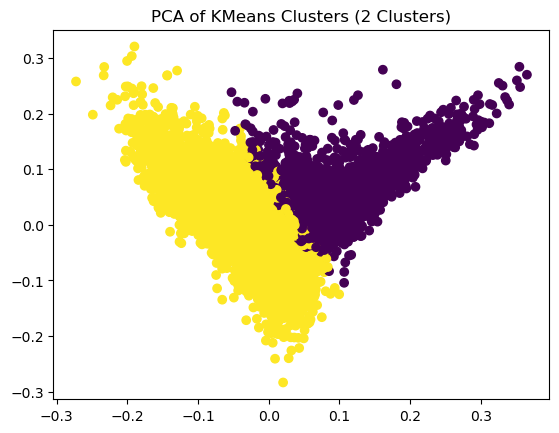

0.066327676


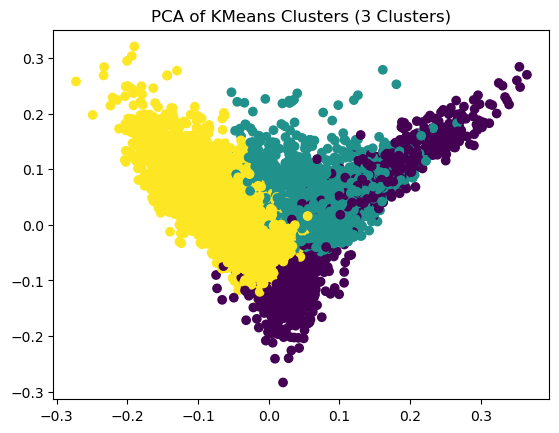

0.0822717


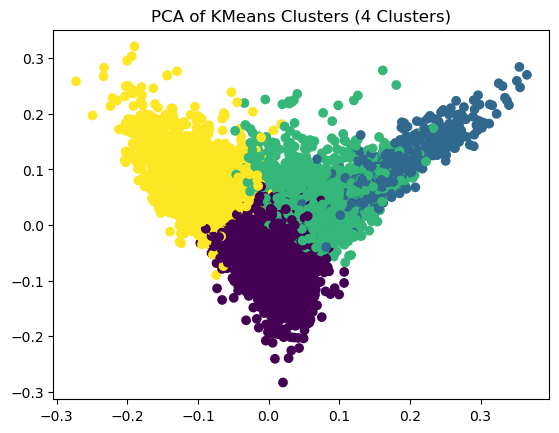

0.038210277


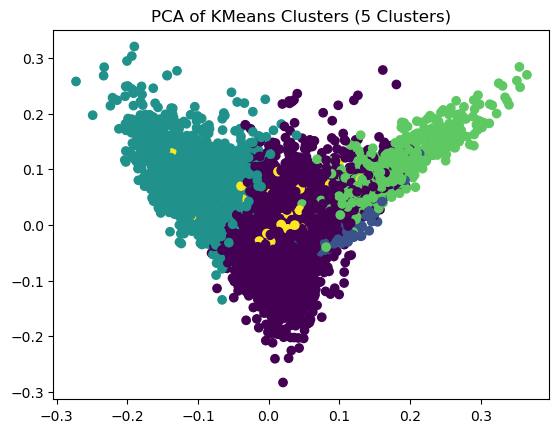

0.06905871


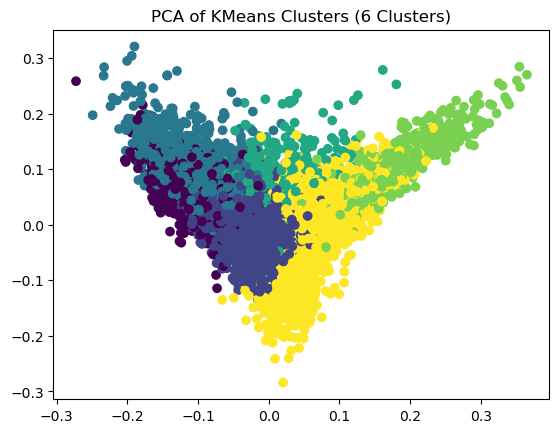

0.060430102


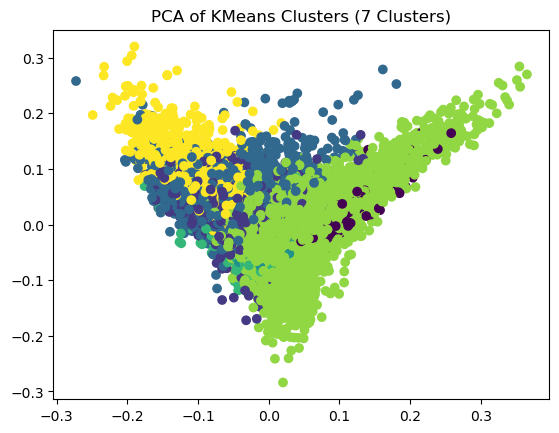

0.051408373


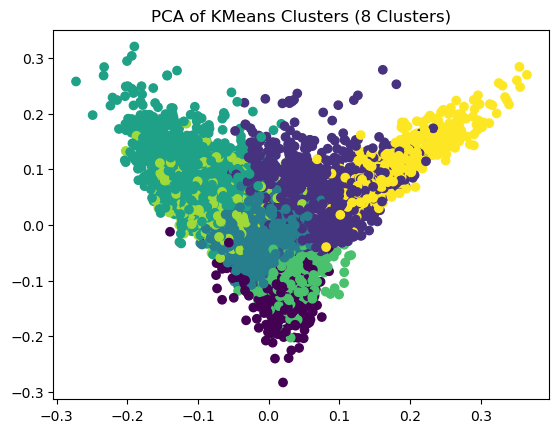

0.1090886


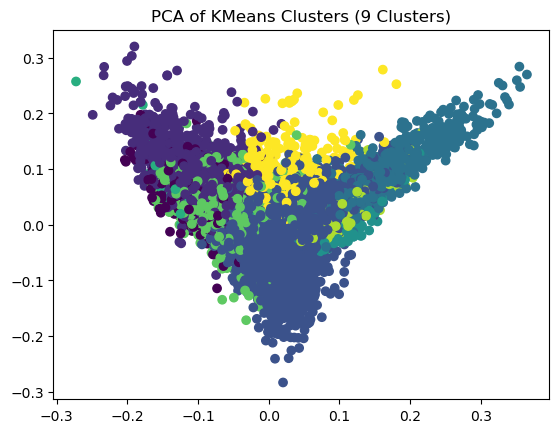

0.058769375


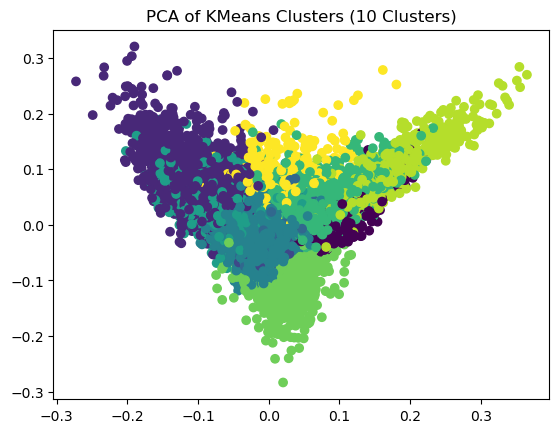

0.03191209


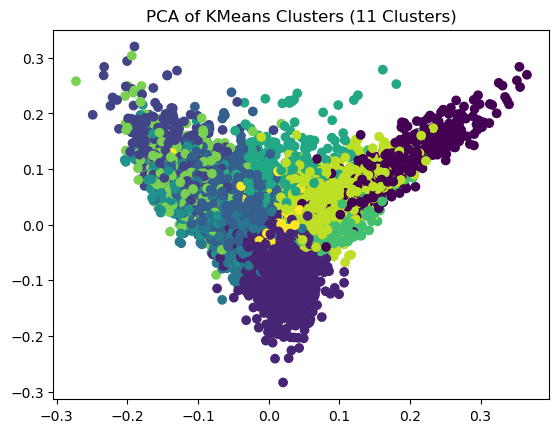

0.07669479


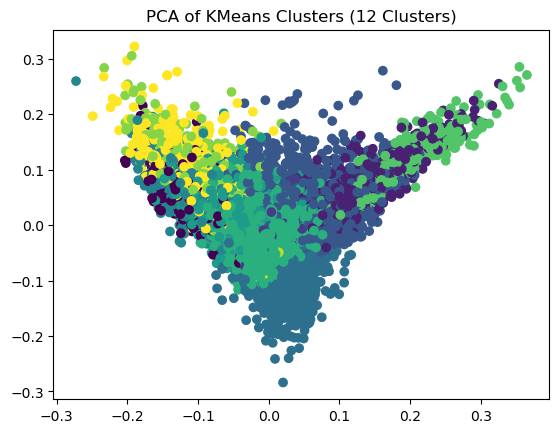

0.06465379


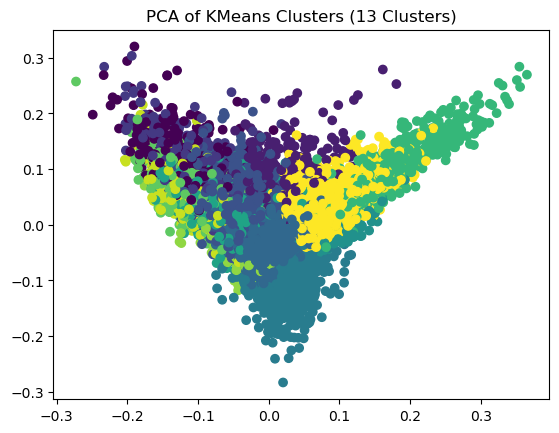

0.07434115


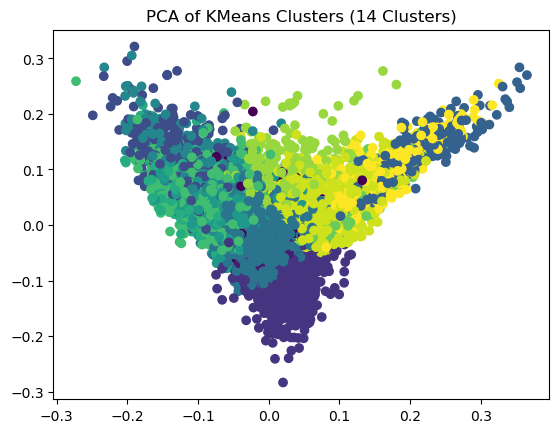

0.06338482


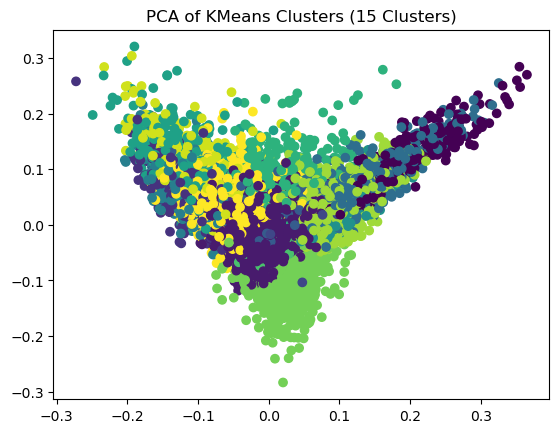

0.05454308


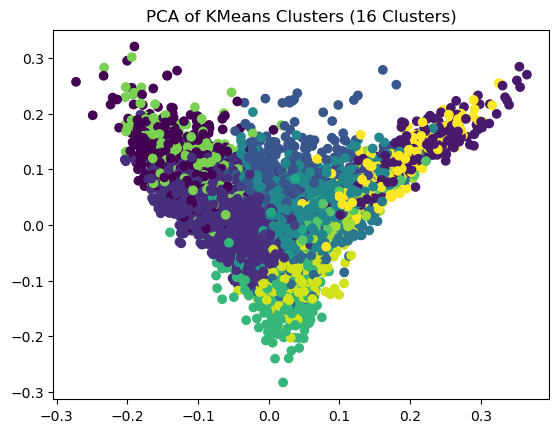

0.061168652


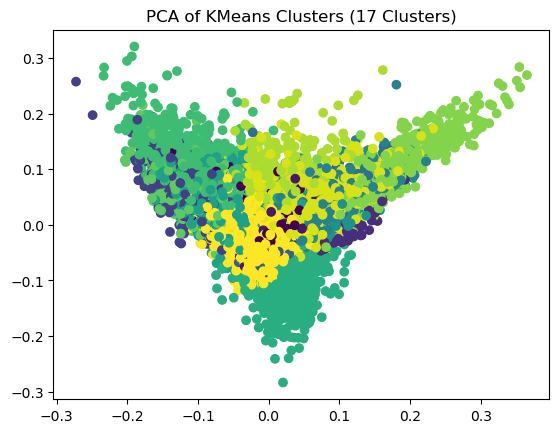

0.047766764


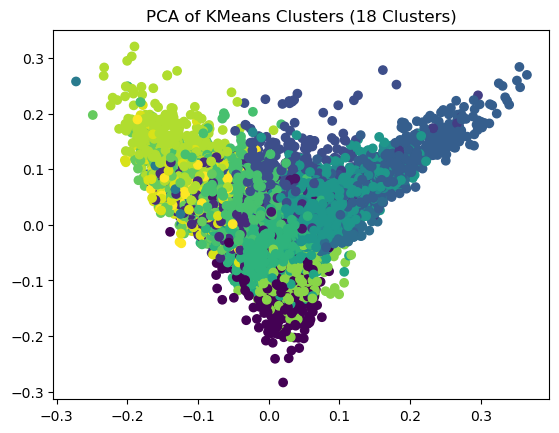

0.051983647


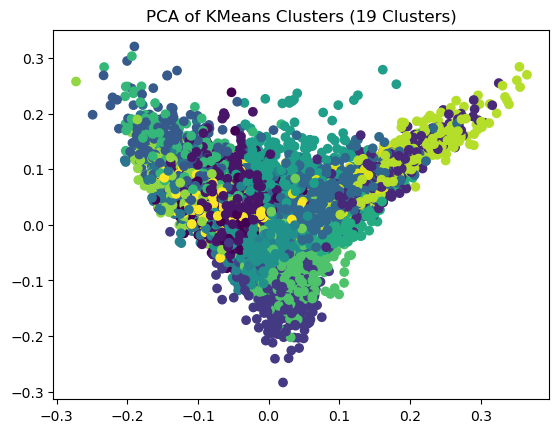

0.055563595


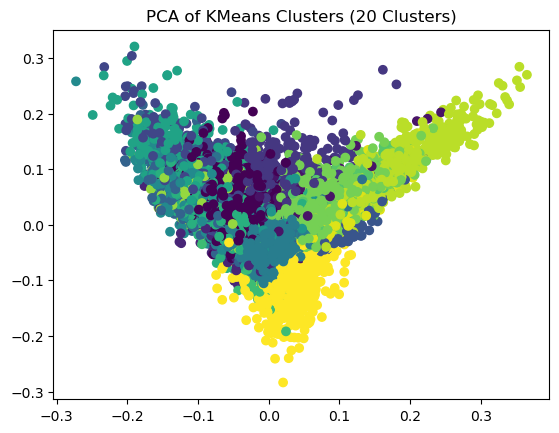

C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_23508\3649969735.py:242: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_23508\3649969735.py:244: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


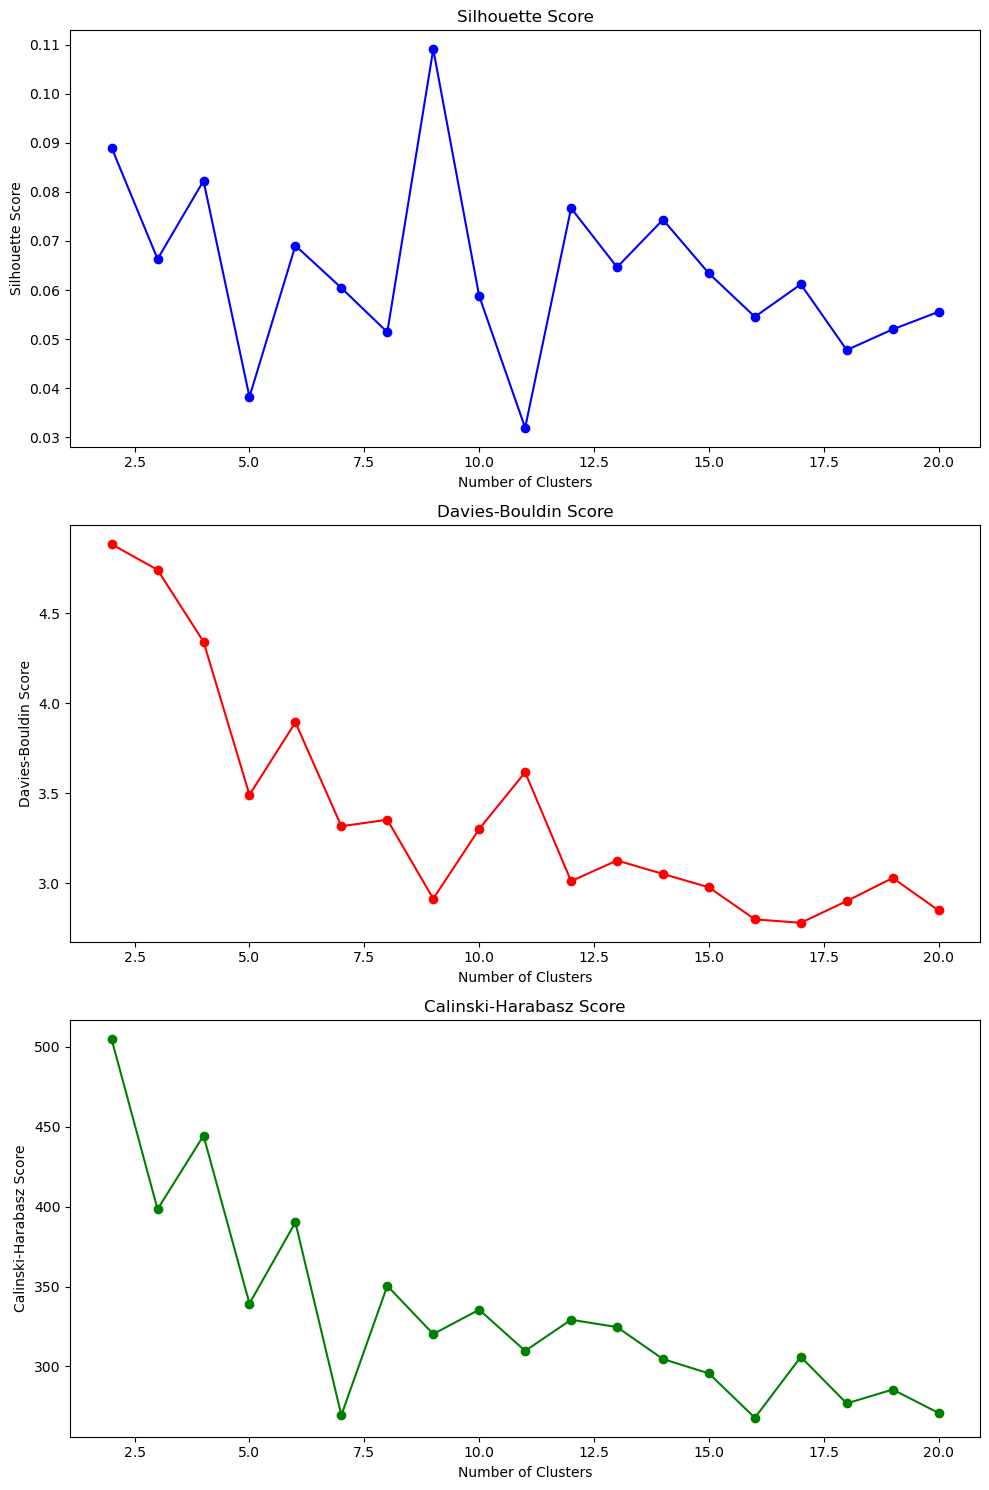

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string


# In[16]:


# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia_and_labels(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia


# In[17]:


class Cuckoo:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.fitness= compute_inertia_and_labels(self.position, data)


# In[12]:


def cuckoo_kmeans(data, n_clusters, n_nests=10, max_iter=100, pa=0.25,kmeans_interval=20):
    cuckoos = [Cuckoo(data, n_clusters) for _ in range(n_nests)]

    for _ in range(max_iter):
        for cuckoo in cuckoos:
            # Generate new solution and calculate its fitness
            new_position = cuckoo.position + np.random.uniform(-1, 1, cuckoo.position.shape)
            new_fitness = compute_inertia_and_labels(new_position, data)

            # Randomly choose a nest
            random_nest = np.random.choice(cuckoos)

            # Replace the worst solution with the new one if it's better
            if new_fitness < random_nest.fitness:
                random_nest.position = new_position
                random_nest.fitness = new_fitness

        # Abandon worse nests and build new ones
        cuckoos.sort(key=lambda x: x.fitness)
        n_abandon = int(n_nests * pa)
        for i in range(n_abandon, n_nests):
            cuckoos[i] = Cuckoo(data, n_clusters)
        if i % kmeans_interval == 0 and i != 0:
            # Using current global best as initial centroids for KMeans refinement
            kmeans = KMeans(n_clusters=n_clusters, init=global_best_position, n_init=1)
            kmeans.fit(data)
            refined_centroids = kmeans.cluster_centers_

            # Update global best if KMeans refinement improves inertia
            refined_inertia, _ = compute_inertia_and_labels(refined_centroids, data)
            if refined_inertia < global_best_score:
                global_best_score = refined_inertia
                global_best_position = refined_centroids

    best_nest = cuckoos[0]
    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(best_nest.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans


# In[13]:


nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()


# In[14]:


def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)


# In[7]:


newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)


# In[8]:


processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)


# In[9]:


if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')


# In[18]:


n_clusters = 2
kmeans = cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)



# In[19]:


silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)


print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")


# In[20]:


from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(tfidf_matrix_reduced)

# Visualizing the clusters
    plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans.labels_)
    plt.title(f'PCA of KMeans Clusters ({n_clusters} Clusters)')
    plt.show()


# In[22]:


import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_countCuckoo-Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_countCuckoo-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_countCuckoo-Kmeans.png")
plt.tight_layout()
plt.show()


# In[23]:


import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df


# In[24]:


df.to_csv('News_tfidf_Cuckoo-Kmeans.csv')


# In[ ]:




